In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import glob
import matplotlib.pyplot as plt
import torchvision

In [51]:
print(torch.__version__)

1.13.1


In [52]:
print(torch.cuda.is_available())

True


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Layer 정의

In [54]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(Block, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias = True, padding_mode = 'reflect'),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    return self.conv(x)

In [55]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super(Discriminator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels, features[0], kernel_size = 4, stride = 2, padding = 1, padding_mode ='reflect'), # Conv(3, 64, 4, 2, 1)
    nn.LeakyReLU(0.2))

    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(Block(in_channels, feature, stride = 1 if feature == features[-1] else 2)) #Conv(64,128, 4, 2, 1),Conv(128,256, 4, 2, 1), Conv(256, 512, 4, 1, 1)  담는다
      in_channels = feature # 
    layers.append(nn.Conv2d(in_channels,1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect')) #Conv(512, 1, 4, 1, 1)
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x = self.initial(x)
    return torch.sigmoid(self.model(x)) # 30 x 30 pathgan

In [56]:
x = torch.randn((5, 3, 256, 256))
model = Discriminator(in_channels = 3)
preds = model(x)
print(preds.shape)
print(preds[0][0])

torch.Size([5, 1, 30, 30])
tensor([[0.4446, 0.4380, 0.5310, 0.6005, 0.4280, 0.4626, 0.5641, 0.5943, 0.4724,
         0.5529, 0.6475, 0.4961, 0.3758, 0.3914, 0.4695, 0.5431, 0.6359, 0.4953,
         0.6315, 0.4190, 0.5205, 0.5346, 0.4300, 0.3776, 0.5396, 0.6210, 0.4353,
         0.5405, 0.4058, 0.5085],
        [0.5060, 0.4569, 0.4585, 0.3814, 0.5820, 0.4200, 0.6438, 0.5827, 0.4547,
         0.6245, 0.5846, 0.5566, 0.5066, 0.6970, 0.7076, 0.5748, 0.4441, 0.4966,
         0.5587, 0.5496, 0.5027, 0.5938, 0.6490, 0.6410, 0.5075, 0.5651, 0.5171,
         0.5338, 0.6170, 0.4130],
        [0.5800, 0.4051, 0.5649, 0.5732, 0.4392, 0.5355, 0.4322, 0.7104, 0.5071,
         0.6205, 0.6641, 0.5395, 0.4374, 0.4114, 0.4997, 0.4308, 0.4467, 0.5171,
         0.5210, 0.3846, 0.5332, 0.6888, 0.5473, 0.5391, 0.5111, 0.4181, 0.4368,
         0.5526, 0.5343, 0.3320],
        [0.4375, 0.4121, 0.5273, 0.5018, 0.5263, 0.4490, 0.4468, 0.4426, 0.5028,
         0.6011, 0.5106, 0.5643, 0.6016, 0.5156, 0.5942, 0.56

In [57]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, padding_mode = 'reflect', **kwargs)
        if down else 
        nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace = True) if use_act else nn.Identity()
    )
  def forward(self, x):
    return self.conv(x)

In [58]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
      ConvBlock(channels, channels, kernel_size = 3, padding = 1),
      ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1)
  )
  def forward(self, x):
    return x + self.block(x)

### 생성기 정의

In [59]:
class Generator(nn.Module):
  def __init__(self, img_channels,num_features = 64, num_resblock = 9):
    super(Generator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(img_channels, num_features, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'),
        nn.ReLU(inplace = True)
    )
    self.down_blocks = nn.ModuleList(
      [
          ConvBlock(num_features, num_features * 2, kernel_size = 3, stride = 2, padding = 1),
       ConvBlock(num_features * 2, num_features * 4, kernel_size = 3, stride = 2, padding = 1),]
    )
    self.residual_block = nn.Sequential(
        *[ResidualBlock(num_features * 4) for _ in range(num_resblock)]
    )

    self.up_blocks = nn.ModuleList(
        [
        ConvBlock(num_features * 4, num_features * 2, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1),
        ConvBlock(num_features * 2, num_features, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1)
    ])
    
    self.last = nn.Conv2d(num_features * 1, img_channels, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect')
  
  def forward(self, x):
    x = self.initial(x)
    for layer in self.down_blocks:
      x = layer(x)
    x= self.residual_block(x)
    for layer in self.up_blocks:
      x = layer(x)
    
    return torch.tanh(self.last(x))

In [60]:
test = torch.randn(2, 3, 256, 256)
gen = Generator(3)
print(gen(test).shape)

torch.Size([2, 3, 256, 256])


In [64]:
transforms_ = [transforms.Resize((256, 256)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
test_trans = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### 데이터셋은 celeb attribute

In [65]:
class Custom_Dataset(Dataset):
  def __init__(self, root, transforms_ = None, mode = 'train'):
    self.transforms = transforms.Compose(transforms_)
    
    self.file_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*')) 
    self.file_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*'))
  
  def __getitem__(self, index):
    itemA = self.transforms(Image.open(self.file_A[index % len(self.file_A)]))
    itemB = self.transforms(Image.open(self.file_B[index % len(self.file_B)]))

    return {'A' : itemA, 'B' : itemB}

  def __len__(self):
    return max(len(self.file_A), len(self.file_B))  

In [66]:
root= "C:\\Users\\User\\Desktop\\GAN proj\\archive\\img_align_celeba\\img_align_celeba_AB\\"
#root = "D:\\다운로드\\archive\\dataAB\\"
batch_size = 32
learning_rate = 2e-4
lambda_identity = 0
lambda_cycle = 10
num_epochs = 200

In [68]:
disc_H = Discriminator(in_channels = 3).to(device)
disc_Z = Discriminator(in_channels = 3).to(device)
gen_Z = Generator(img_channels = 3, num_resblock = 9).to(device)
gen_H = Generator(img_channels = 3, num_resblock = 9).to(device)

optim_disc = optim.Adam(list(disc_H.parameters()) + list(disc_Z.parameters()),
                        lr = learning_rate, betas = (0.5, 0.999))
optim_gen = optim.Adam(list(gen_Z.parameters()) + list(gen_H.parameters()),
                       lr = learning_rate, betas = (0.5, 0.999))
L1 = nn.L1Loss()
mse = nn.MSELoss()

In [69]:
dataset = Custom_Dataset(
     root, transforms_ = transforms_
)
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)

In [70]:
imagea = next(iter(dataloader))['A'][0]
imageb = next(iter(dataloader))['B'][0]

In [71]:
imagea

tensor([[[-0.3255, -0.3333, -0.3333,  ..., -0.5059, -0.5059, -0.5059],
         [-0.3255, -0.3333, -0.3333,  ..., -0.5059, -0.5059, -0.5059],
         [-0.3255, -0.3333, -0.3333,  ..., -0.5059, -0.5059, -0.5059],
         ...,
         [-0.2314, -0.2235, -0.2235,  ..., -0.0588, -0.0667, -0.0588],
         [-0.2235, -0.2157, -0.2157,  ..., -0.0275, -0.0431, -0.0510],
         [-0.2235, -0.2157, -0.2157,  ..., -0.0353, -0.0275, -0.0353]],

        [[-0.2706, -0.2784, -0.2784,  ..., -0.5059, -0.5059, -0.5059],
         [-0.2706, -0.2784, -0.2784,  ..., -0.5059, -0.5059, -0.5059],
         [-0.2706, -0.2784, -0.2784,  ..., -0.5059, -0.5059, -0.5059],
         ...,
         [-0.1529, -0.1451, -0.1451,  ..., -0.2706, -0.2941, -0.2863],
         [-0.1451, -0.1373, -0.1373,  ..., -0.2471, -0.2706, -0.2784],
         [-0.1451, -0.1373, -0.1373,  ..., -0.2549, -0.2549, -0.2627]],

        [[-0.3255, -0.3333, -0.3333,  ..., -0.5686, -0.5686, -0.5686],
         [-0.3255, -0.3333, -0.3333,  ..., -0

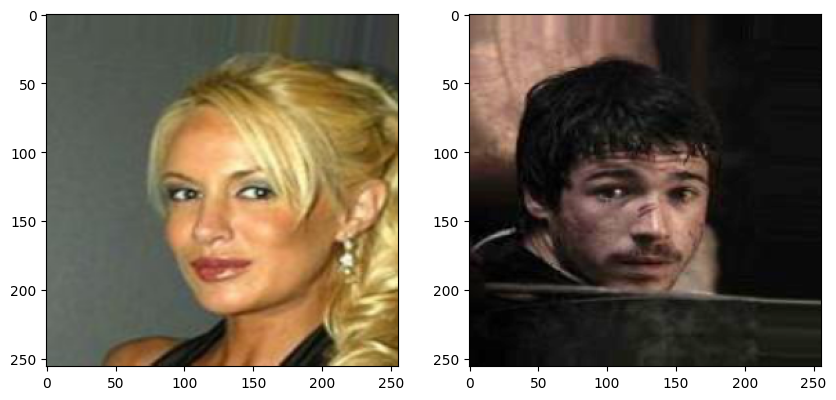

In [72]:
plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid(imagea, normalize = True).permute(1, 2, 0)) #a 안경 X
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(imageb, normalize = True).permute(1, 2, 0)) #b 안경 O

In [73]:
print(imagea.size())
print(imageb.size())

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [74]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [75]:
# disc_H = Discriminator(in_channels = 3).to(device) = disc_A
# disc_Z = Discriminator(in_channels = 3).to(device) = disc_O
# gen_Z = Generator(img_channels = 3, num_resblock = 9).to(device) = gen_O
# gen_H = Generator(img_channels = 3, num_resblock = 9).to(device) = gen_A
# zebra = orange, horse = apple

for epoch in range(num_epochs):
  for idx, batch in enumerate(dataloader):
  
    orange = batch['B'].to(device)
    apple = batch['A'].to(device)
    optim_disc.zero_grad()
    optim_gen.zero_grad()

    fake_apple = gen_H(orange) 
    D_A_real = disc_H(apple) 
    D_A_fake = disc_H(fake_apple.detach()) 
    D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
    D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake)) 
    D_A_loss = D_A_real_loss + D_A_fake_loss 

    fake_orange = gen_Z(apple)
    D_O_real = disc_Z(orange)
    D_O_fake = disc_Z(fake_orange.detach())
    D_O_real_loss = mse(D_O_real, torch.ones_like(D_O_real))
    D_O_fake_loss = mse(D_O_fake, torch.zeros_like(D_O_fake))
    D_O_loss = D_O_real_loss + D_O_fake_loss

    D_loss = (D_A_loss + D_O_loss) / 2

    D_loss.backward()
    optim_disc.step()
    #generator 학습
    D_A_fake = disc_H(fake_apple)
    D_O_fake = disc_Z(fake_orange)
    loss_G_A = mse(D_O_fake, torch.ones_like(D_A_fake)) #CE 를 쓰지않고 여기서 정의된 새로운 손실함수 
    loss_G_O = mse(D_O_fake, torch.ones_like(D_O_fake))

    cycle_orange = gen_Z(fake_apple)
    cycle_apple = gen_H(fake_orange)
    cycle_orange_loss = L1(orange, cycle_orange)
    cycle_apple_loss = L1(apple, cycle_apple)

    identity_orange = gen_Z(orange)
    identity_apple = gen_H(apple)
    identity_orange_loss = L1(orange, identity_orange)
    identity_apple_loss = L1(apple, identity_apple)

    G_loss = (loss_G_O + loss_G_A + cycle_orange_loss * lambda_cycle + cycle_apple_loss * lambda_cycle
              +identity_apple_loss * lambda_identity + identity_orange_loss * lambda_identity)
    G_loss.backward()
    optim_gen.step()
    if idx == 50:
      print('EPOCH : ', epoch, 'G_loss : ', G_loss, 'D_loss :', D_loss)
      break

EPOCH :  0 G_loss :  tensor(7.0694, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4308, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  1 G_loss :  tensor(5.3097, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4593, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  2 G_loss :  tensor(4.9015, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4366, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  3 G_loss :  tensor(4.9878, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.5184, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  4 G_loss :  tensor(6.1105, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.3966, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  5 G_loss :  tensor(4.7252, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.2309, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  6 G_loss :  tensor(5.1068, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.2396, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH 

### 모델 저장

In [83]:
torch.save(gen_H, 'gen_H.pth')
torch.save(gen_Z, 'gen_Z.pth')

In [78]:
apple_image = next(iter(dataloader))['A'][1]
orange_image = next(iter(dataloader))['B'][1]

In [79]:
apple_image = apple_image.to(device)
orange_image = orange_image.to(device)

모델에 이미지 넣어서 결과 확인.
나름 잘 변환된 것을 확인할 수 있다.

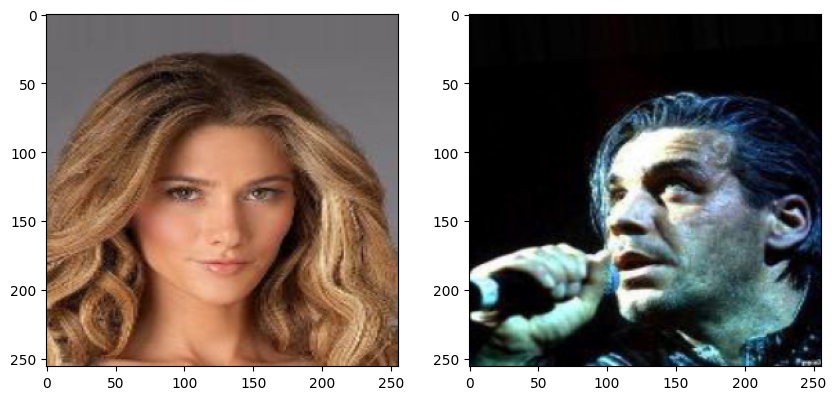

In [80]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(apple_image.cpu(), normalize = True).permute(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(orange_image.cpu(), normalize = True).permute(1, 2, 0)) 

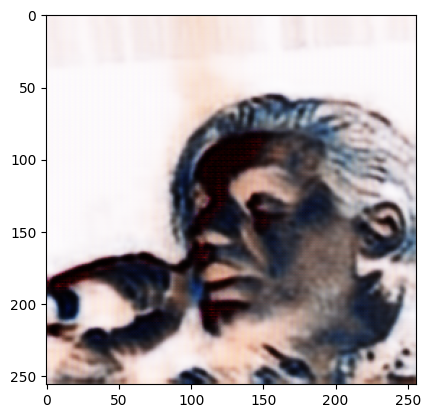

In [81]:
trans_apple = gen_H(orange_image).cpu()
plt.imshow(torchvision.utils.make_grid(trans_apple.cpu(), normalize = True).permute(1, 2, 0)) 

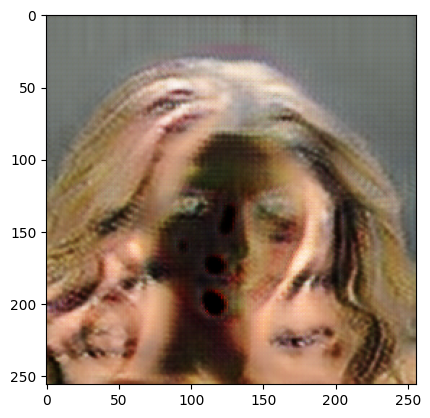

In [82]:
trans_orange = gen_Z(apple_image).cpu()
plt.imshow(torchvision.utils.make_grid(trans_orange.cpu(), normalize = True).permute(1, 2, 0)) 